In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats

from utils.cross_validation import cross_validate
from utils.metrics import aucroc
from utils.estimators import ForestTreeWrapper
from utils.randomized_search import rs_results
from utils.base_set import X_train, y_train, seed

### Forest

In [2]:
n = X_train.shape[0]
p = X_train.shape[1]
model = RandomForestClassifier()
k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": stats.randint(1, 4),
    "max_features": stats.randint(1, p),
}
n_iter = 100
classifier_RForest = RandomizedSearchCV(estimator=model, 
                                    param_distributions=params, 
                                    n_iter=n_iter, 
                                    cv=cv, 
                                    scoring='roc_auc',
                                    verbose=True,
                                    random_state=seed)
classifier_RForest.fit(X_train, y_train)
rs_results(classifier_RForest.cv_results_, params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
# best_params = classifier_RForest.best_params_
# del best_params["max_features"]
best_params = {'criterion': 'log_loss', 'max_depth': 3}
print(best_params)
print(p)

{'criterion': 'log_loss', 'max_depth': 3}
200


### Curva de complejidad

In [ ]:
mean_val_scores = []
std_val_scores = []
mean_train_scores = []
std_train_scores = []

k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
cols_val = [f"split_val_{i}" for i in range(k)]
cols_train = [f"split_train_{i}" for i in range(k)]
max_features_values =  [1, 2, 3, 5, 7, 10, 15, 25, 40, 60, 80, 100, 120, 140, 160, 180, 200]
for mf in max_features_values:
    rf = ForestTreeWrapper(**best_params, max_features=mf, random_state=seed)
    auc_scores, _ = cross_validate(rf, X_train, y_train, metric=aucroc, use_decision=True, cv=cv)
    mean_val_scores.append(auc_scores.mean_val.aucroc)
    std_val_scores.append(auc_scores[cols_val].std(axis=1).aucroc)
    mean_train_scores.append(auc_scores.mean_train.aucroc)
    std_train_scores.append(auc_scores[cols_train].std(axis=1).aucroc)

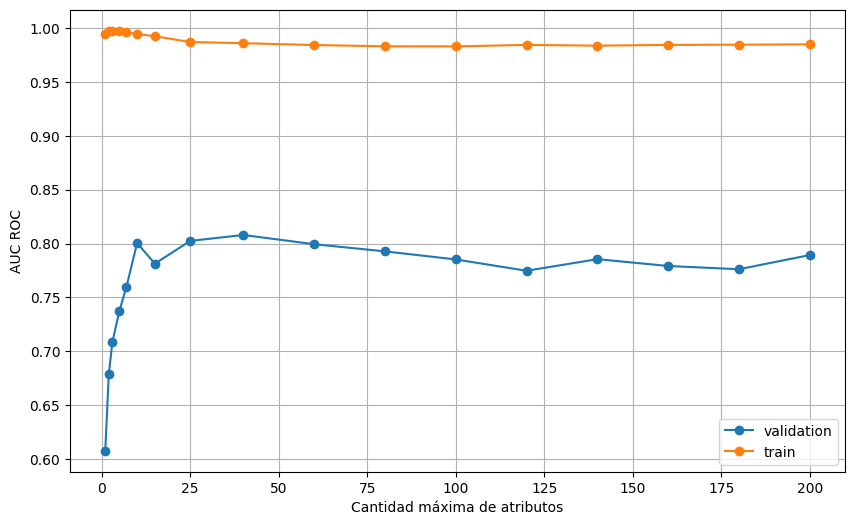

In [ ]:
plt.figure(figsize=(10, 6))
# plt.errorbar(max_features_values, mean_val_scores, std_val_scores, fmt='-o', label="validation")
plt.plot(max_features_values, mean_val_scores, '-o', label="validation")
plt.plot(max_features_values, mean_train_scores,'-o', label="train")
plt.errorbar(max_features_values, mean_train_scores, std_train_scores, fmt='-o', label="train")
plt.scatter(max_features_values, mean_train_scores, label="train")

plt.plot()
plt.legend()
plt.xlabel('Cantidad máxima de atributos')
plt.ylabel('AUC ROC')
# plt.title('Curva de Complejidad para Árbol de Decisión (criterion=Entropy)')
plt.grid(True)
plt.show()

In [ ]:
max(mean_val_scores)

0.8079921614700695

### Curva de aprendizaje

In [ ]:
mean_val_scores = []
std_val_scores = []
mean_train_scores = []
std_train_scores = []
 
best_params = best_params
best_params["max_features"] = 30
k = 5
n = X_train.shape[0]
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
cols_val = [f"split_val_{i}" for i in range(k)]
cols_train = [f"split_train_{i}" for i in range(k)]
train = range(30, n, 10)
for idx in train:
    rf = ForestTreeWrapper(**best_params, random_state=seed)
    auc_scores, _ = cross_validate(rf, X_train[:idx,], y_train[:idx,], metric=aucroc, use_decision=True, cv=cv)
    mean_val_scores.append(auc_scores.mean_val.aucroc)
    std_val_scores.append(auc_scores[cols_val].std(axis=1).aucroc)
    mean_train_scores.append(auc_scores.mean_train.aucroc)
    std_train_scores.append(auc_scores[cols_train].std(axis=1).aucroc)

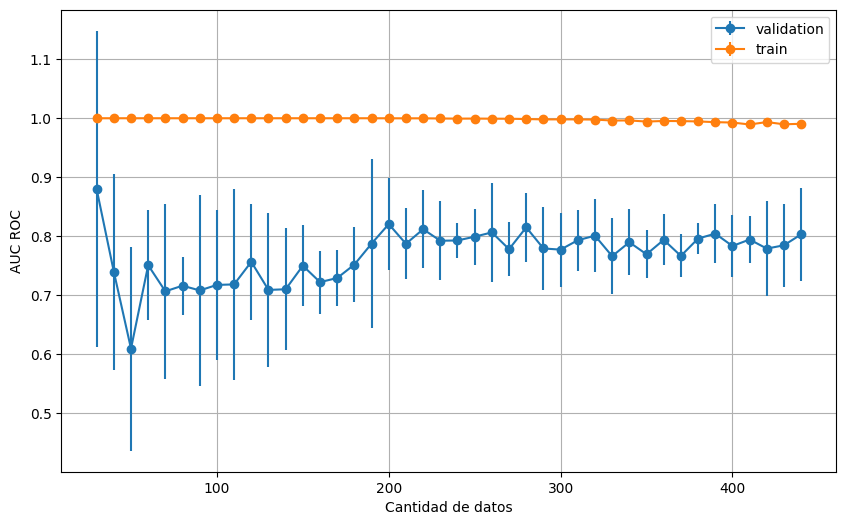

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(train, mean_val_scores, std_val_scores, fmt='-o', label="validation")
plt.errorbar(train, mean_train_scores, std_train_scores, fmt='-o', label="train")
plt.legend()
plt.xlabel('Cantidad de datos')
plt.ylabel('AUC ROC')
# plt.title('Curva de Complejidad para Árbol de Decisión (criterion=Entropy)')
plt.grid(True)
plt.show()